In [1]:
using Plots
using ParticleFilters
using Distributions
using StaticArrays
using LinearAlgebra
using Random
using StatsBase
using Reel

using GridInterpolations
using DataStructures
using DataFrames
using CSV

In [2]:

include("atan2.jl")
include("obs_rel.jl")
include("polargrid_rel_qual.jl")
rng = MersenneTwister(2);
#

In [3]:
# random walk

POS_0 = [6.0, 60.0]
CRS_0 = 90 # target's course
SPD_0 = 1 # 1 or 2
TGT_SPD = 1

#input is course in degrees and rng
#returns next course in degrees
function next_crs(crs,rng)
    if rand(rng) < .9
        return crs
    end
    crs = (crs + rand(rng,[-1,1])*30) % 360
    if crs < 0 crs += 360 end
    return crs
end

# state as tuple (x, y, crs, spd) of target (spd of o/s)
function f(state, control, rng)
    r, θ, crs, spd = state
    θ += control[1]
    spd = control[2]
    if θ < 0 θ += 360 end
    θ = θ % 360
    crs -= control[1]
    if crs < 0 crs += 360 end
    crs = crs % 360
    x = r*cos(π/180*θ)
    y = r*sin(π/180*θ)
    pos = [x + TGT_SPD*cos(π/180*crs) - spd, y + 
        TGT_SPD*sin(π/180*crs)]
    crs = next_crs(crs,rng)
    r = sqrt(pos[1]^2 + pos[2]^2)
    θ = atan2(pos[1],pos[2])*180/π
    if θ < 0 θ += 360 end
    return (r, θ, crs, spd)::NTuple{4, Real}
end
#

f (generic function with 1 method)

In [4]:
function r(s)
    range = s[1]
    if range > 150 return -.1 end  # reward to not lose track of contact
    if range <= 10 return -1 end  # collision avoidance
    return .1  # being in "sweet spot" maximizes reward
end
#

r (generic function with 1 method)

In [6]:
#angles = [0, 30, 60, 90, 120, 150, 210, 240, 270, 300, 330]

statespace = thestates
actionspace = ((30,1), (0,1), (-30,1), (30, 2), (0,2), (-30,2))

action_index(a) = trunc(Int, 2*(a[1]/30+1) + a[2])
actions_ = ((-30,1), (-30, 2), (0, 1), (0, 2), (30, 1), (30, 2))



((-30, 1), (-30, 2), (0, 1), (0, 2), (30, 1), (30, 2))

In [7]:
# returns vector rather than Tuple, for particle filter
function f2(x, u, rng)
    temp = [i for i in f(x, u, rng)]
    return temp
end

f2 (generic function with 1 method)

In [8]:
totals = [0.0]
#θ = zeros(length(grid),6);
θ = [r(Tuple(ind2x(grid, j))) for j in 1:length(grid), i in 1:6];

In [9]:

N = 500
model = ParticleFilterModel{Vector{Float64}}(f2, g)
pfilter = SIRParticleFilter(model, N);
α = 0.5
γ = 0.9
ϵ = .3
x = [20, 60, 90, 1, 1];
λ = 0.8
b = ParticleCollection([[20, 60, 90, 1] for i in 1:N]);
counter = 0


0

In [ ]:
## Q-learning loop
plots = []
betas = Deque{Array}()
β = zeros(length(grid),6);

epochs = 1000
epochsize = 500
last = 0

total = 0
ξ = weighted_grid_2(b)/N
for i in 1:(epochsize*epochs)
    counter += 1
    
    
    # choose next action
    u = next_action([transpose(θ[:,j])*ξ for j in 1:size(θ)[2]], ϵ, rng)
    
    #observe new state and reward
    xp = f2(x, actions_[u], rng)
    y = h(xp, rng)
    b = update(pfilter, b, actions_[u], y)
    rew = r(Tuple(xp))
       
    ξ = weighted_grid_2(b)/N
    β[:,u] = ξ

    total += rew
    #v = 10^3*sqrt(var(ξ))
    if length(betas) < 20
        pushfirst!(betas, [β,u])
    else
        pop!(betas)
        pushfirst!(betas, [β,u])
    end
    
    cur = (rew + γ * max2([transpose(θ[:,j])*ξ for j in 1:size(θ)[2]], rng))
    #println(cur)
    
    #update θ
    #θ += α * cur *β
    for (j, bet) in enumerate(betas)
        θ[:,bet[2]] *= (1 - ((λ^j) * α))
        θ += (λ^j) * α * cur * bet[1]
    end
    
    
    last = transpose(θ[:,u])*ξ

    if counter % epochsize == 0
        push!(totals, total*500/epochsize)
        #ϵ = max(min((20000 - 2*total)/180000, 1), 0)
        println("--------- CURRENT: ", total*500/epochsize, " AVG: ", mean(totals), " Epoch: ", 
            trunc(Int, counter/epochsize), " -----------")
        total = 0
        xp = [rand(rng, 25:120), rand(rng,0:359), rand(rng,0:11)*30, 1, 1];
        #@show xp
        b = ParticleCollection([xp[1:4] for i in 1:N]);
        #last = 0
    end
    x = xp
    
    
    #plotting
    #r_ = [row[1] for row in particles(b)]
    #theta = [row[2] for row in particles(b)]*π/180
    #x_theta = x[2]*π/180
    #x_r = x[1]
    
    #print(".")
    #plt = plot(proj=:polar, lims=(0,200), size=(1000,1000))
    #scatter!(theta, r_, markersize=1, label="particles")
    #scatter!([x_theta], [x_r], markersize=3, label="target")
          
    #push!(plots, plt)
    
end


--------- CURRENT: 38.10000000000027 AVG: 34.66756756756788 Epoch: 36 -----------
--------- CURRENT: 50.00000000000044 AVG: 35.07105263157926 Epoch: 37 -----------
--------- CURRENT: 23.600000000000378 AVG: 34.776923076923396 Epoch: 38 -----------
--------- CURRENT: 50.00000000000044 AVG: 35.157500000000326 Epoch: 39 -----------
--------- CURRENT: 50.00000000000044 AVG: 35.519512195122275 Epoch: 40 -----------
--------- CURRENT: 50.00000000000044 AVG: 35.86428571428604 Epoch: 41 -----------
--------- CURRENT: -13.999999999999968 AVG: 34.704651162791016 Epoch: 42 -----------
--------- CURRENT: 3.4000000000000012 AVG: 33.99318181818214 Epoch: 43 -----------
--------- CURRENT: 50.00000000000044 AVG: 34.348888888889206 Epoch: 44 -----------
--------- CURRENT: 50.00000000000044 AVG: 34.68913043478293 Epoch: 45 -----------
--------- CURRENT: 50.00000000000044 AVG: 35.0148936170216 Epoch: 46 -----------
--------- CURRENT: 50.00000000000044 AVG: 35.32708333333366 Epoch: 47 -----------
--------

--------- CURRENT: -18.399999999999995 AVG: 33.07352941176501 Epoch: 135 -----------
--------- CURRENT: 37.80000000000027 AVG: 33.10802919708059 Epoch: 136 -----------
--------- CURRENT: 50.00000000000044 AVG: 33.230434782608995 Epoch: 137 -----------
--------- CURRENT: 50.00000000000044 AVG: 33.35107913669094 Epoch: 138 -----------
--------- CURRENT: -15.399999999999965 AVG: 33.00285714285744 Epoch: 139 -----------
--------- CURRENT: 34.200000000000216 AVG: 33.01134751773079 Epoch: 140 -----------
--------- CURRENT: -1.0000000000000007 AVG: 32.771830985915784 Epoch: 141 -----------
--------- CURRENT: -23.80000000000007 AVG: 32.376223776224066 Epoch: 142 -----------
--------- CURRENT: 50.00000000000044 AVG: 32.498611111111394 Epoch: 143 -----------
--------- CURRENT: 50.00000000000044 AVG: 32.619310344827866 Epoch: 144 -----------
--------- CURRENT: 50.00000000000044 AVG: 32.738356164383845 Epoch: 145 -----------
--------- CURRENT: 50.00000000000044 AVG: 32.85578231292545 Epoch: 146 --

28080-element Array{Float64,1}:
  5.0e-324               
  5.0e-324               
  5.0e-324               
  5.0e-324               
  5.0e-324               
  5.0e-324               
  5.0e-324               
  6.334296630747041e-142 
  4.408302493370503e-140 
  2.1111996101566677e-142
  0.00026924035607655834 
  0.003562785670388458   
  0.001918845413691756   
  ⋮                      
 -5.0e-324               
 -5.0e-324               
 -5.0e-324               
 -5.0e-324               
 -5.0e-324               
 -5.0e-324               
 -5.0e-324               
 -5.0e-324               
 -5.0e-324               
 -5.0e-324               
 -5.0e-324               
 -5.0e-324               

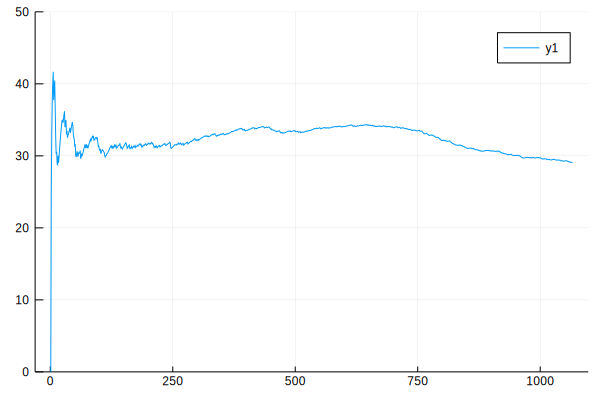

In [29]:
xx = []
yy = []
yyy = []
for (i, t) in enumerate(totals)
    push!(xx, i)
    push!(yy, t)
    push!(yyy, mean(yy))
end

plot(xx, yyy, ylims = (0,50))

2.0131182926706272e35

In [102]:
thetaframe = DataFrame(θ)
CSV.write("0.43_theta_11.27_1", thetaframe)

"0.43_theta_11.26_1"

In [51]:
b = ParticleCollection([[20, 60, 90, 1] for i in 1:N]);
ξ = weighted_grid_2(b)/N
var(ξ)


3.5612535612535624e-5